# Temperature and salinity transect across the Arctic

This notebook uses the `CellPath` object to select a transect across the Arctic and plots the temperature and salinity. 

In [1]:
import sys
import os
import numpy as np
import cartopy.crs as ccrs
sys.path.append("..")
from mpasview import *

In [2]:
# mesh file
meshroot = os.environ['HOME']+'/data/mpas/grids'
meshfile = meshroot+'/oEC60to30v3_60layer.170905.nc'

In [3]:
mpasmesh = MPASMesh(name='oEC60to30v3',filepath=meshfile)
print(mpasmesh)

<class 'mpasview.data.MPASMesh'>:
        name: oEC60to30v3
      ncells: 235160
      nedges: 714274
   nvertices: 478835
   on sphere: True


In [4]:
# load bathymetry
varname = 'bottomDepth'
fmesh = xr.open_dataset(meshfile)
bath = fmesh[varname].data

In [5]:
# define MPASOMap
mpasomap = MPASOMap(data=bath, name='Bottom depth', units='m',
                     mesh=mpasmesh)
print(mpasomap)

<class 'mpasview.data.MPASOMap'> (size=235160):
    name: Bottom depth
   units: m
    data: [82.471041 5476.726684 ... 4525.246844 5499.990273]
     lon: [185.336578 129.033944 ... 262.142174 143.990351]
     lat: [62.198095 18.467407 ... -68.167836 11.803854]
    mesh: oEC60to30v3
position: cell


## Transect across the Arctic

Define a transect across the Arctic by connecting multiple smaller transects between each pair of endpoitns. 

In [6]:
%%time
# set endpoints (Atlantic to Pacific)
lons = [327., 327., 340., 352., 360.,  40., 220., 191., 191., 182.]
lats = [ 45.,  64.,  68.,  73.,  80.,  85.,  75.,  72.,  65.,  45.]
nref = [   5,    2,    2,    3,    3,    5,    2,    2,    5]
npnt = len(lons)
# reverse the order (Pacific to Atlantic)
lons.reverse()
lats.reverse()
nref.reverse()
# print endpoints
print('Endpoints:')
for i in np.arange(npnt):
    print('    P{:d}: {:4.1f} {:4.1f}'.format(i, lons[i], lats[i]))
# compute paths 
path = CellPath()
dist_sec = [0.]
for i in np.arange(npnt-1):
    # get the shortest path
    path_sec = mpasmesh.get_shortest_path_cell(
        lons[i], lats[i], lons[i+1], lats[i+1],
        npoint_ref=nref[i], debug_info=False) 
    # connect paths
    path = path + path_sec
    # get the cumulative distance (sum of the distances between 
    # the cell centers, not the great circles)
    dist_tmp = []
    for j in np.arange(len(path_sec.icell)-1):
        dist_tmp.append(gc_distance(path_sec.xcell[j],
                                    path_sec.ycell[j],
                                    path_sec.xcell[j+1],
                                    path_sec.ycell[j+1]))
    dist_sec.append(np.sum(dist_tmp))
print(path)
# distance
distance_sec = np.cumsum(dist_sec)
print(distance_sec)

Endpoints:
    P0: 182.0 45.0
    P1: 191.0 65.0
    P2: 191.0 72.0
    P3: 220.0 75.0
    P4: 40.0 85.0
    P5: 360.0 80.0
    P6: 352.0 73.0
    P7: 340.0 68.0
    P8: 327.0 64.0
    P9: 327.0 45.0
Cell closest to P0: 181.72230 44.96165
Cell closest to P1: 191.07875 65.26608
 - Cell closest to RefP1: 182.82450 48.08065
 - Cell closest to RefP2: 183.58641 51.62514
 - Cell closest to RefP3: 185.42301 55.06753
 - Cell closest to RefP4: 186.68936 58.32637
 - Cell closest to RefP5: 188.86187 61.77776
Cell closest to P0: 191.07875 65.26608
Cell closest to P1: 190.95828 71.87250
 - Cell closest to RefP1: 191.24520 67.74400
 - Cell closest to RefP2: 190.75878 69.72306
Cell closest to P0: 190.95828 71.87250
Cell closest to P1: 220.29431 75.24389
 - Cell closest to RefP1: 199.27863 73.68664
 - Cell closest to RefP2: 209.39767 74.69960
Cell closest to P0: 220.29431 75.24389
Cell closest to P1: 39.56688 85.03406
 - Cell closest to RefP1: 220.43314 78.52030
 - Cell closest to RefP2: 220.62362 82.

Plotting 'Bottom depth (m)' map in the 'Arctic' (19805 data points)...


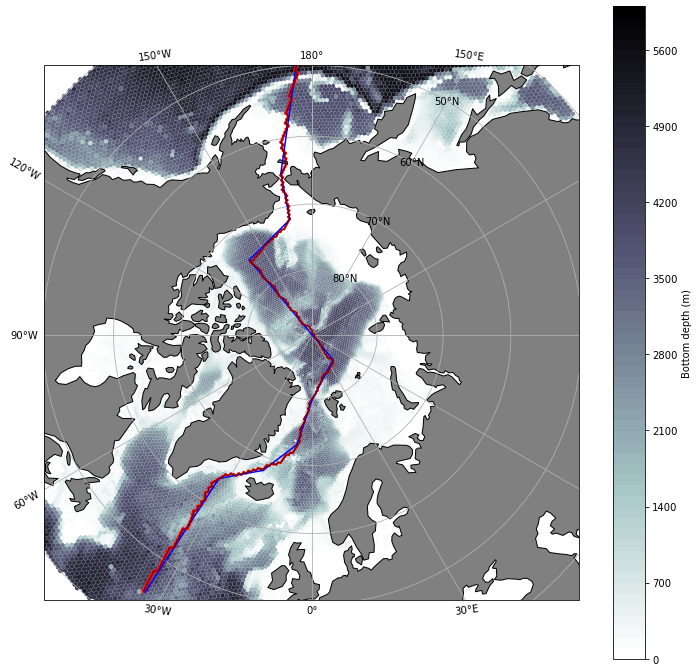

In [7]:
plt.figure(figsize=[12,12])
levels = np.linspace(0, 6000, 61)
m = mpasomap.plot(region='Arctic', levels=levels, cmap='bone_r',
                 ptype='pcolor')
# plot cross sections
for i in np.arange(npnt-1):
    plt.plot([lons[i], lons[i+1]], [lats[i], lats[i+1]],
             color='b', transform=ccrs.Geodetic())
# plot path
path.project_cell_filled(m, mpasmesh, facecolors='r' )
path.project_cell_center(m, c='darkred')

## Plot the T/S transects

Plot the temperature and salinity transects by selecting the temperautre and salinity profiles at cells on the path.

In [8]:
# read depth
bottom_depth = fmesh['refBottomDepth'].data
depth = np.zeros_like(bottom_depth)
depth[0] = -0.5*bottom_depth[0]
depth[1:] = -0.5*(bottom_depth[0:-1]+bottom_depth[1:])
print(depth.shape)

(60,)


In [9]:
# compute distance
dist = [0.]
for i in np.arange(len(path.icell)-1):
    dist.append(gc_distance(path.xcell[i], path.ycell[i],
                           path.xcell[i+1], path.ycell[i+1]))
distance = np.asarray(np.cumsum(dist))
print(distance.shape)

(327,)


### Temperature

In [10]:
# read temperature
varname = 'temperature'
temp = fmesh[varname].data[0,path.icell,:]
temp[temp<-1.e8] = np.nan
print(temp.shape)

(327, 60)


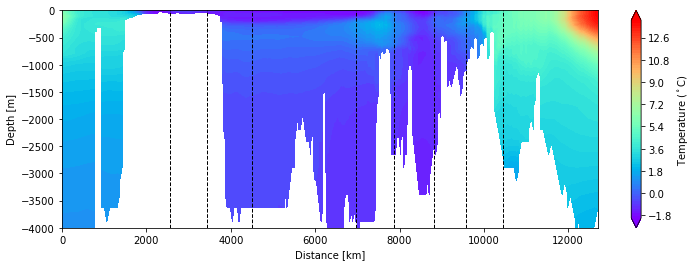

In [11]:
plt.figure(figsize=[12,4])
levels = np.linspace(-2, 14, 81)
plt.contourf(distance, depth, temp.T, levels=levels,
             extend='both', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Temperature ($^\circ$C)')
plt.ylim([-4000, 0])
plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
# add section boundary
for i in np.arange(npnt-2):
    plt.vlines(x=distance_sec[i+1], ymin=-4000, ymax=0,
              color='black', linewidth=1, linestyle='--')

### Salinity

In [12]:
# read salinity
varname = 'salinity'
salt = fmesh[varname].data[0,path.icell,:]
salt[salt<-1.e8] = np.nan
print(salt.shape)

(327, 60)


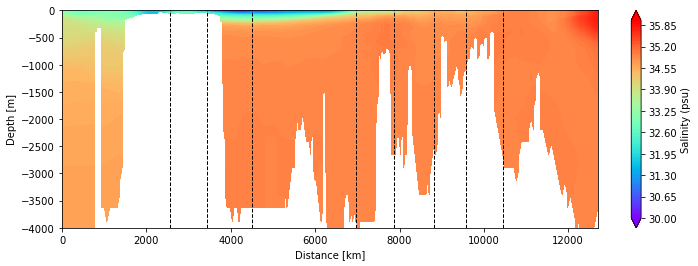

In [13]:
plt.figure(figsize=[12,4])
levels = np.linspace(30, 36, 121)
plt.contourf(distance, depth, salt.T, levels=levels,
             extend='both', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Salinity (psu)')
plt.ylim([-4000, 0])
plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
# add section boundary
for i in np.arange(npnt-2):
    plt.vlines(x=distance_sec[i+1], ymin=-4000, ymax=0,
              color='black', linewidth=1, linestyle='--')